US Medicare Payment Data - comparison of payments among states
==============================================================

In this script we compare Medicare payments in 2012 between several states.  There are many ways to do this.  For example, we could look at the total or average of all payments to all providers in a state.  However the total payment at the state level would scale with the size of the state, and the average payment may be affected by the composition of patients and providers within the state.  To reduce these effects, we can look at the average payment made within a state to all providers of a specific type, or for all services of a particular type.  These averages can then be compared between states.

The CMS payment data can be obtained [here](http://www.cms.gov/Research-Statistics-Data-and-Systems/Statistics-Trends-and-Reports/Medicare-Provider-Charge-Data/Physician-and-Other-Supplier.html).

[Here](http://www.cms.gov/Research-Statistics-Data-and-Systems/Statistics-Trends-and-Reports/Medicare-Provider-Charge-Data/Downloads/Medicare-Physician-and-Other-Supplier-PUF-Methodology.pdf) is some documentation about the data set.  

First we import the libraries that we will use in the script.

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Next we read in the data for each state that we intend to analyze.  We use a dictionary comprehension to create a dictionary that maps the two-letter state name string to the Pandas DataFrame object for the state.

In [2]:
state_names = ["FL", "MI"]
fnames = [x + "-subset.csv.gz" for x in state_names]
state_data = {k: pd.read_csv(f, compression="gzip") for (k, f) in zip(state_names, fnames)}
print([type(state_data[k]) for k in state_names])
print([state_data[k].shape for k in state_names])

[<class 'pandas.core.frame.DataFrame'>, <class 'pandas.core.frame.DataFrame'>]
[(667995, 27), (339456, 27)]


We plan to focus on individual providers here, so we exclude the provider organizations.

In [3]:
for k in state_names:
    ix = (state_data[k].loc[:, "nppes_entity_code"] == "I")
    state_data[k] = state_data[k].loc[ix, :]
    print(state_data[k].shape)

(636249, 27)
(329457, 27)


### Comparing mean payments by provider type

We start by calculating the total medicare payment for each type of service within each provider, within each state.

In [4]:
for k in state_names:
    state_data[k]["total_payment"] = state_data[k]["line_srvc_cnt"] * state_data[k]["average_Medicare_payment_amt"]
    print(state_data[k].shape)

(636249, 28)
(329457, 28)


The simplest comparison is to look at the total of all payments by state.  We calculate this quantity in the next cell (in billions of US dollars).  If we are comparing Florida to Michigan, Florida's total population is 19.3 million and Michigan's is 9.8 million.  Florida's population of people over 65 years old is 4.1 million, and Michigan's is 1.5 million.  

In [5]:
tot = {k : state_data[k].loc[:, "total_payment"].sum() / 1e9 for k in state_names}
print(tot)
print("FL/MI payent ratio: %.3f" % (tot["FL"] / tot["MI"]))
print("FL/MI population ratio: %.3f" % (19.3 / 9.8))
print("Fl/MI 65+ population ratio: %.3f" % (4.1 / 1.5))

{'FL': 6.5373885239300451, 'MI': 2.433227685210483}
FL/MI payent ratio: 2.687
FL/MI population ratio: 1.969
Fl/MI 65+ population ratio: 2.733


Next we aggregate the data by provider, taking the sum of all payments to each provider within each state.  Again we use dictionary comprehensions, so the result is a dictionary mapping state abbreviations to a DataFrames containing the aggregated values.  We aggregate the payments by summing, and we aggregate the provider type by taking the first value within the group (since it is constant within each group).  The `first` function extracts the first element from a Pandas `Series` object.

In [6]:
first = lambda x: x.iloc[0]

by_provider = {k: state_data[k].groupby("npi").agg({"total_payment": np.sum, "provider_type": first}) for k in state_names}
print({k: type(by_provider) for k in state_names})
print({k: by_provider[k].shape for k in state_names})

{'FL': <class 'dict'>, 'MI': <class 'dict'>}
{'FL': (49076, 2), 'MI': (31138, 2)}


This is what we have at this point:

In [7]:
print(state_names[0])
print(by_provider[state_names[0]].head())

FL
            total_payment       provider_type
npi                                          
1003000381       16411.12  Physical Therapist
1003000522       97836.25     Family Practice
1003000720        7019.95  Nurse Practitioner
1003001462       27597.83  Radiation Oncology
1003002817      129028.63     Family Practice


Next we aggregate again, this time aggregating over all providers of a given type.

In [8]:
by_provider_type = {k: by_provider[k].groupby("provider_type").agg(np.mean) for k in state_names}
print({k: type(by_provider_type[k]) for k in state_names})
print({k: by_provider_type[k].shape for k in state_names})

{'FL': <class 'pandas.core.frame.DataFrame'>, 'MI': <class 'pandas.core.frame.DataFrame'>}
{'FL': (75, 1), 'MI': (73, 1)}


A few provider types are used in one state but not the other:

In [9]:
ptypes = {k: by_provider_type[k].index for k in state_names}
print(set(ptypes["MI"]) - set(ptypes["FL"]))
print(set(ptypes["FL"]) - set(ptypes["MI"]))

{'Unknown Supplier/Provider'}
{'Unknown Physician Specialty Code', 'Independent Diagnostic Testing Facility', 'Peripheral Vascular Disease'}


This is what these data look like for one state, the numbers are the average total payment to a provider of a given type within the state:

In [10]:
by_provider_type["MI"].head()

,total_payment
provider_type,
Addiction Medicine,121745.735000
Allergy/Immunology,53693.749917
Anesthesiologist Assistants,3732.635000
Anesthesiology,36701.068349
Audiologist (billing independently),5019.827558


Up to this point, we had a separate data set for the each state.  Now that we have reduced the data to the main quantity of interest, we can merge the state-level data sets into a single data set, to make it easier to compare the states.

In [11]:
for k in state_names:
    by_provider_type[k].columns = [k]
by_provider_type = pd.concat(list(by_provider_type.values()), axis=1)

Here is a peek at the merged data set:

In [12]:
print(by_provider_type.head())

                                                FL             MI
Addiction Medicine                    14961.302222  121745.735000
Allergy/Immunology                   102898.723737   53693.749917
Anesthesiologist Assistants           11456.243731    3732.635000
Anesthesiology                        41096.014748   36701.068349
Audiologist (billing independently)   12976.023042    5019.827558


Since some provider types are not present in a given state, after merging their payment value will be `nan`.  We can confirm that here:

In [13]:
print(pd.isnull(by_provider_type).sum())

FL    1
MI    3
dtype: int64


In this setting, it might be reasonable to replace the missing values with zero:

In [14]:
by_provider_type = by_provider_type.replace(np.nan, 0)
print(pd.isnull(by_provider_type).sum())

FL    0
MI    0
dtype: int64


Next we make a scatterplot showing the average payments by provider type in one state versus the other.

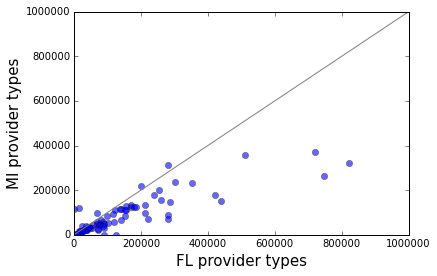

In [15]:
plt.plot(by_provider_type.loc[:, state_names[0]], by_provider_type.loc[:, state_names[1]], 'o', alpha=0.6)
plt.plot([0, 1e6], [0, 1e6], '-', color='grey')
plt.xlabel(state_names[0] + " provider types", size=15)
plt.ylabel(state_names[1] + " provider types", size=15)

Since the payment levels are quite skewed, we will plot them on a log scale.  Note that the zeros that were introduced into the dataset will become `nan` after taking the log, and hence will be dropped from the plot.  This is OK because those probably reflect administrative differences in how the coding is handled, rather than being true zeros.

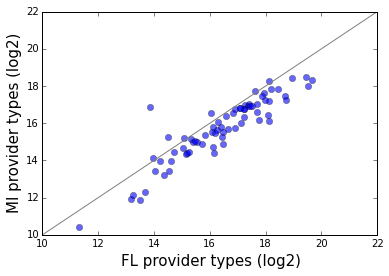

In [16]:
x = np.log(by_provider_type.loc[:, state_names[0]]) / np.log(2)
y = np.log(by_provider_type.loc[:, state_names[1]]) / np.log(2)
plt.plot(x, y, 'o', alpha=0.6)
plt.plot([10, 22], [10, 22], '-', color='grey')
plt.xlabel(state_names[0] + " provider types (log2)", size=15)
plt.ylabel(state_names[1] + " provider types (log2)", size=15)

We can also drill down and examine some of the provider types with the greatest difference in payment levels between the two states.

In [17]:
ii = (y - x > 2)
print(by_provider_type.loc[ii, :])

                                     FL           MI
Addiction Medicine         14961.302222  121745.7350
Unknown Supplier/Provider      0.000000  115743.6225


In [18]:
ii = (x - y > 2)
print(by_provider_type.loc[ii, :])

                                                    FL         MI
Independent Diagnostic Testing Facility   15037.770000      0.000
Nuclear Medicine                         281914.943600  70312.875
Peripheral Vascular Disease              126513.343333      0.000
Unknown Physician Specialty Code          90887.808889      0.000


### Comparison by service type

A different way to make the comparison is by aggregating in terms of service types.

In [19]:
by_service_type = {k: state_data[k].groupby("hcpcs_code").agg({"average_Medicare_payment_amt": np.mean, "hcpcs_description": first}) for k in state_names}
print(by_service_type["FL"].head())

            average_Medicare_payment_amt         hcpcs_description
hcpcs_code                                                        
00103                         136.483071     Anesth blepharoplasty
00104                          64.475266       Anesth electroshock
00120                         142.361123        Anesth ear surgery
00126                          60.844473        Anesth tympanotomy
00140                         128.521658  Anesth procedures on eye


Next we concatenate the state-level results into a single data frame.  First we rename the variable of interest to the state's name.

In [20]:
for k in state_names:
    by_service_type[k].rename(columns = {"average_Medicare_payment_amt": k}, inplace=True)
by_service_type = pd.concat(list(by_service_type.values()), axis=1)
print(by_service_type.shape)
print(by_service_type.head())

(3903, 4)
               FL         hcpcs_description          MI  \
00103  136.483071     Anesth blepharoplasty   93.955017   
00104   64.475266       Anesth electroshock   46.538973   
00120  142.361123        Anesth ear surgery  150.657667   
00126   60.844473        Anesth tympanotomy   44.884947   
00140  128.521658  Anesth procedures on eye  100.105619   

              hcpcs_description  
00103     Anesth blepharoplasty  
00104       Anesth electroshock  
00120        Anesth ear surgery  
00126        Anesth tympanotomy  
00140  Anesth procedures on eye  


After concatenating, the hcpcs_description column will be duplicated, since this column was present in the data file for each state.  We don't really need to remove the extra copy, but we can.

In [21]:
ii = np.flatnonzero(by_service_type.columns == "hcpcs_description")
jj = [0, 1, 2, 3]
jj.remove(ii[1])
by_service_type = by_service_type.iloc[:, jj]
print(by_service_type.head())

               FL         hcpcs_description          MI
00103  136.483071     Anesth blepharoplasty   93.955017
00104   64.475266       Anesth electroshock   46.538973
00120  142.361123        Anesth ear surgery  150.657667
00126   60.844473        Anesth tympanotomy   44.884947
00140  128.521658  Anesth procedures on eye  100.105619


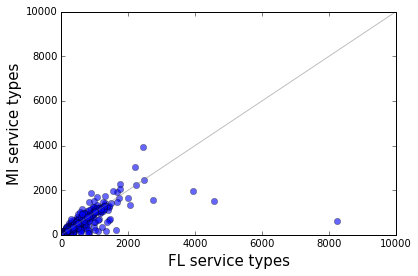

In [22]:
plt.plot(by_service_type.loc[:, state_names[0]], by_service_type.loc[:, state_names[1]], 'o', alpha=0.6)
plt.plot([0, 1e4], [0, 1e4], '-', color='grey', alpha=0.5)
plt.xlabel(state_names[0] + " service types", size=15)
_ = plt.ylabel(state_names[1] + " service types", size=15)

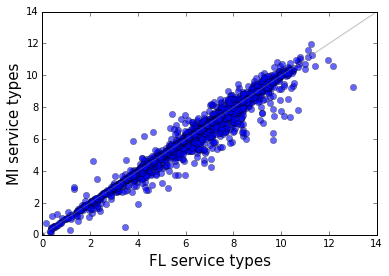

In [23]:
x = np.log(by_service_type.loc[:, state_names[0]]) / np.log(2)
y = np.log(by_service_type.loc[:, state_names[1]]) / np.log(2)
plt.plot(x, y, 'o', alpha=0.6)
plt.plot([0, 14], [0, 14], '-', color='grey', alpha=0.5)
plt.xlim(0, 14)
plt.ylim(0, 14)
plt.xlabel(state_names[0] + " service types", size=15)
_ = plt.ylabel(state_names[1] + " service types", size=15)

Another way to compare the two states is to examine the distribution of provider total payments.  A quantile-quantile (QQ) plot shows in detail how two distributions differ.

In [24]:
provider_totals = {k: state_data[k].groupby("npi").agg({"total_payment": np.sum}) for k in state_names}
print(provider_totals["MI"].head())

            total_payment
npi                      
1003000605       19619.11
1003001884       28618.18
1003003021      107302.65
1003005315       67463.36
1003006503       35688.16


We will need the a set of percentiles from the two data sets.

In [25]:
log_provider_totals = {k : np.log10(provider_totals[k]) for k in state_names}
q = np.linspace(1, 99, 50).tolist()
pctls = {k: np.percentile(log_provider_totals[k], q) for k in state_names}
q = np.linspace(10, 91, 9).tolist()
dcls = {k: np.percentile(log_provider_totals[k], q) for k in state_names}

Here is the QQ plot.  It shows that Michigan providers receive lower payments than Florida providers at every point in the distribution.

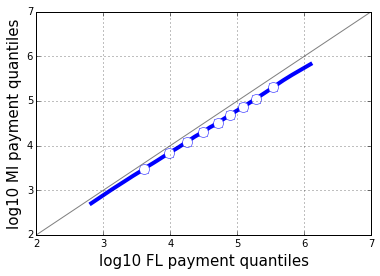

In [26]:
plt.plot(pctls[state_names[0]], pctls[state_names[1]], '-', lw=4)
plt.plot(dcls[state_names[0]], dcls[state_names[1]], 'o', ms=10, mec='blue', mfc='white')
plt.plot([2, 7], [2, 7], '-', color='grey')
plt.grid(True)
plt.xlabel("log10 " + state_names[0] + " payment quantiles", size=15)
_ = plt.ylabel("log10 " + state_names[1] + " payment quantiles", size=15)

__Exercises:__

* Compare the states' total Medicare payments in terms of the number of unique beneficiaries, and the number of unique beneficiary days (see the data documentation for the variable names).  Interpret the results relative to the states' population sizes and Medicare eligible (65 years of age or older) population sizes.

* Calculate the proportion of providers in each state who belong to each provider type.  Compare these proportions between the two states using some of the techniques demonstrated above.

* Repeat some of the analyses above using alternative measures to count the services (number of unique beneficiaries and number of unique beneficiary days). 